# 日経平均株価 日足

In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = '^N225'
ticker = yf.Ticker(symbol)

df = ticker.history(period='1y')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-12-04 00:00:00+09:00,33318.070312,33324.378906,33023.039062,33231.269531,87300000,0.0,0.0
2023-12-05 00:00:00+09:00,33022.378906,33089.820312,32726.679688,32775.820312,86100000,0.0,0.0
2023-12-06 00:00:00+09:00,32928.921875,33452.128906,32914.089844,33445.898438,91200000,0.0,0.0
2023-12-07 00:00:00+09:00,33165.718750,33195.871094,32814.691406,32858.308594,105100000,0.0,0.0
2023-12-08 00:00:00+09:00,32600.470703,32604.349609,32205.380859,32307.859375,144200000,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-27 00:00:00+09:00,38327.859375,38332.449219,37988.988281,38134.968750,120500000,0.0,0.0
2024-11-28 00:00:00+09:00,37935.941406,38478.320312,37801.621094,38349.058594,103400000,0.0,0.0
2024-11-29 00:00:00+09:00,38205.078125,38270.058594,37986.968750,38208.031250,102300000,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

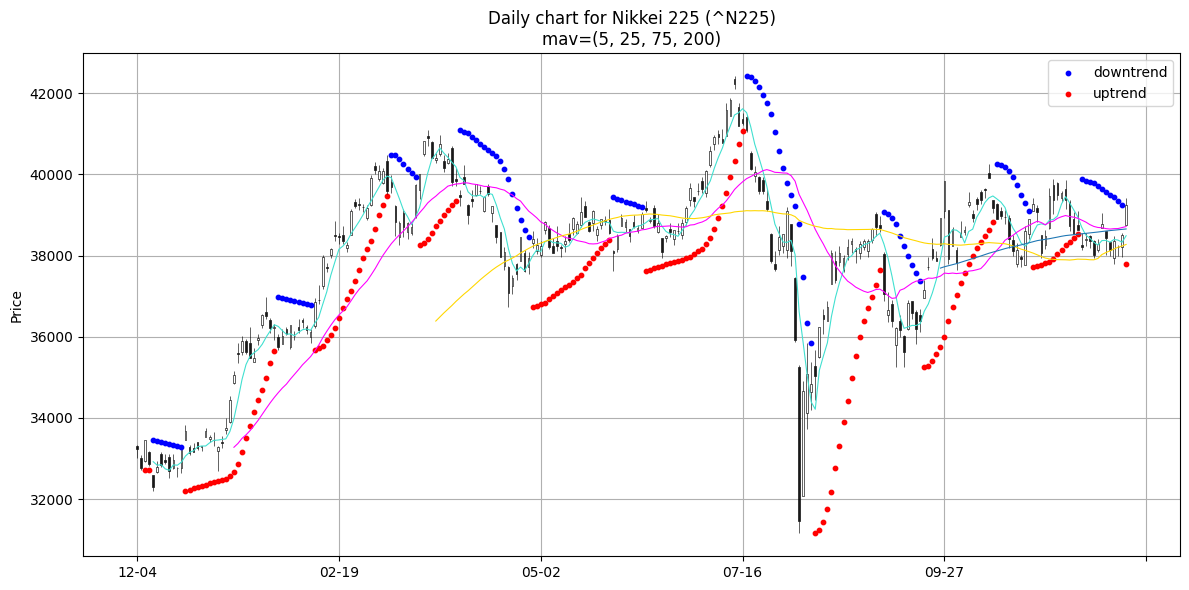

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75, 200),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75, 200)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75, 200)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_n225.png')
plt.show()

In [4]:
df.tail(2)['Close']

Date
2024-11-28 00:00:00+09:00    38349.058594
2024-11-29 00:00:00+09:00    38208.031250
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2024-11-28 00:00:00+09:00           NaN
2024-11-29 00:00:00+09:00   -141.027344
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(25).mean()

Date
2023-11-29 00:00:00+09:00             NaN
2023-11-30 00:00:00+09:00             NaN
2023-12-01 00:00:00+09:00             NaN
2023-12-04 00:00:00+09:00             NaN
2023-12-05 00:00:00+09:00             NaN
                                 ...     
2024-11-25 00:00:00+09:00    38686.998906
2024-11-26 00:00:00+09:00    38666.494844
2024-11-27 00:00:00+09:00    38655.415156
2024-11-28 00:00:00+09:00    38665.183125
2024-11-29 00:00:00+09:00    38667.772812
Name: Close, Length: 247, dtype: float64

In [7]:
df['Close'].rolling(75).mean()

Date
2023-11-29 00:00:00+09:00             NaN
2023-11-30 00:00:00+09:00             NaN
2023-12-01 00:00:00+09:00             NaN
2023-12-04 00:00:00+09:00             NaN
2023-12-05 00:00:00+09:00             NaN
                                 ...     
2024-11-25 00:00:00+09:00    38027.045000
2024-11-26 00:00:00+09:00    38077.265521
2024-11-27 00:00:00+09:00    38117.870156
2024-11-28 00:00:00+09:00    38164.775625
2024-11-29 00:00:00+09:00    38207.216042
Name: Close, Length: 247, dtype: float64

In [8]:
df['Close'].rolling(200).mean()

Date
2023-11-29 00:00:00+09:00             NaN
2023-11-30 00:00:00+09:00             NaN
2023-12-01 00:00:00+09:00             NaN
2023-12-04 00:00:00+09:00             NaN
2023-12-05 00:00:00+09:00             NaN
                                 ...     
2024-11-25 00:00:00+09:00    38596.180186
2024-11-26 00:00:00+09:00    38607.600088
2024-11-27 00:00:00+09:00    38616.504131
2024-11-28 00:00:00+09:00    38627.446123
2024-11-29 00:00:00+09:00    38637.886670
Name: Close, Length: 247, dtype: float64